# Lab 01b: Convolutional Neural Networks

## Why convolutions?
###### This part of the lab is based on the [2022 edition of Full Stack Deep Learning Lecture](https://fullstackdeeplearning.com/course/2022/).

The most basic neural networks,
multi-layer perceptrons,
are built by alternating
parameterized linear transformations
with non-linear transformations.

This combination is capable of expressing
[functions of arbitrary complexity](http://neuralnetworksanddeeplearning.com/chap4.html),
so long as those functions
take in fixed-size arrays and return fixed-size arrays.

```python
def any_function_you_can_imagine(x: torch.Tensor["A"]) -> torch.Tensor["B"]:
    return some_mlp_that_might_be_impractically_huge(x)
```

But not all functions have that type signature.

For example, we might want to identify the content of images
that have different sizes.
Without gross hacks,
an MLP won't be able to solve this problem,
even though it seems simple enough.

In [1]:
import os
import sys
nb_dir = os.getcwd()
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

/Users/marbetschar/Development/zhaw/MLOps_Labs/lab01


In [2]:
import random
import IPython.display as display

randsize = 10 ** (random.random() * 2 + 1)
filename = "imgs/U.png"

# run this cell multiple times to display the same image at different sizes
# the content of the image remains unambiguous
display.Image(filename=filename, width=randsize, height=randsize)

Even worse, MLPs are too general to be efficient.

Each layer applies an unstructured matrix to its inputs.
But most of the data we might want to apply them to is highly structured,
and taking advantage of that structure can make our models more efficient.

It may seem appealing to use an unstructured model:
it can in principle learn any function.
But
[most functions are monstrous outrages against common sense](https://en.wikipedia.org/wiki/Weierstrass_function#Density_of_nowhere-differentiable_functions).
It is useful to encode some of our assumptions
about the kinds of functions we might want to learn
from our data into our model's architecture.

## Convolutions are the local, translation-equivariant linear transforms.

One of the most common types of structure in data is "locality" --
the most relevant information for understanding or predicting a pixel
is a small number of pixels around it.

Locality is a fundamental feature of the physical world,
so it shows up in data drawn from physical observations,
like photographs and audio recordings.

Locality means most meaningful linear transformations of our input
only have large weights in a small number of entries that are close to one another,
rather than having equally large weights in all entries.

In [3]:
import torch

generic_linear_transform = torch.randn(8, 1)
print("generic:", generic_linear_transform, sep="\n")

local_linear_transform = torch.tensor(
    [[0, 0, 0] + [random.random(), random.random(), random.random()] + [0, 0]]
).T
print("local:", local_linear_transform, sep="\n")

generic:
tensor([[-0.8100],
        [ 1.2359],
        [ 0.0151],
        [ 0.8159],
        [-0.7333],
        [ 0.9476],
        [-0.8264],
        [-0.8871]])
local:
tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.3725],
        [0.3508],
        [0.4192],
        [0.0000],
        [0.0000]])


Another type of structure commonly observed is "translation equivariance" --
the top-left pixel position is not, in itself, meaningfully different
from the bottom-right position
or a position in the middle of the image.
Relative relationships matter more than absolute relationships.

Translation equivariance arises in images because there is generally no privileged
vantage point for taking the image.
We could just as easily have taken the image while standing a few feet to the left or right,
and all of its contents would shift along with our change in perspective.

Translation equivariance means that a linear transformation that is meaningful at one position
in our input is likely to be meaningful at all other points.
We can learn something about a linear transformation from a datapoint where it is useful
in the bottom-left and then apply it to another datapoint where it's useful in the top-right.

In [4]:
generic_linear_transform = torch.arange(8)[:, None]
print("generic:", generic_linear_transform, sep="\n")

equivariant_linear_transform = torch.stack(
    [torch.roll(generic_linear_transform[:, 0], ii) for ii in range(8)], dim=1
)
print("translation invariant:", equivariant_linear_transform, sep="\n")

generic:
tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]])
translation invariant:
tensor([[0, 7, 6, 5, 4, 3, 2, 1],
        [1, 0, 7, 6, 5, 4, 3, 2],
        [2, 1, 0, 7, 6, 5, 4, 3],
        [3, 2, 1, 0, 7, 6, 5, 4],
        [4, 3, 2, 1, 0, 7, 6, 5],
        [5, 4, 3, 2, 1, 0, 7, 6],
        [6, 5, 4, 3, 2, 1, 0, 7],
        [7, 6, 5, 4, 3, 2, 1, 0]])


A linear transformation that is translation equivariant
[is called a _convolution_](https://en.wikipedia.org/wiki/Convolution#Translational_equivariance).

If the weights of that linear transformation are mostly zero
except for a few that are close to one another,
that convolution is said to have a _kernel_.

In [5]:
# the equivalent of torch.nn.Linear, but for a 1-dimensional convolution
conv_layer = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3)

conv_layer.weight  # aka kernel

Parameter containing:
tensor([[[-0.0748,  0.4580, -0.3589]]], requires_grad=True)

Instead of using normal matrix multiplication to apply the kernel to the input,
we repeatedly apply that kernel over and over again,
"sliding" it over the input to produce an output.

Every convolution kernel has an equivalent matrix form,
which can be matrix multiplied with the input to create the output:

> <small> Under the hood, the actual operation that implements the application of a convolutional kernel
need not look like either of these
(common approaches include
[Winograd-type algorithms](https://arxiv.org/abs/1509.09308)
and [Fast Fourier Transform-based algorithms](https://arxiv.org/abs/1312.5851)).</small>

Though they may seem somewhat arbitrary and technical,
convolutions are actually a deep and fundamental piece of mathematics and computer science.
Fundamental as in
[closely related to the multiplication algorithm we learn as children](https://charlesfrye.github.io/math/2019/02/20/multiplication-convoluted-part-one.html)
and deep as in
[closely related to the Fourier transform](https://math.stackexchange.com/questions/918345/fourier-transform-as-diagonalization-of-convolution).
Generalized convolutions can show up
wherever there is some kind of "sum" over some kind of "paths",
as is common in dynamic programming.

In the context of this course,
we don't have time to dive much deeper on convolutions or convolutional neural networks.

See Chris Olah's blog series
([1](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/),
[2](https://colah.github.io/posts/2014-07-Understanding-Convolutions/),
[3](https://colah.github.io/posts/2014-12-Groups-Convolution/))
for a friendly introduction to the mathematical view of convolution.

For more on convolutional neural network architectures, see
[the lecture notes from Stanford's 2020 "Deep Learning for Computer Vision" course](https://cs231n.github.io/convolutional-networks/).

Images have two dimensions of translation equivariance:
left/right and up/down.
So we use two-dimensional convolutions,
instantiated in `torch.nn` as `nn.Conv2d` layers.
Note that convolutional neural networks for images
are so popular that when the term "convolution"
is used without qualifier in a neural network context,
it can be taken to mean two-dimensional convolutions.

Where `Linear` layers took in batches of vectors of a fixed size
and returned batches of vectors of a fixed size,
`Conv2d` layers take in batches of two-dimensional _stacked feature maps_
and return batches of two-dimensional stacked feature maps.

A pseudocode type signature based on
[`torchtyping`](https://github.com/patrick-kidger/torchtyping)
might look like:

```python
StackedFeatureMapIn = torch.Tensor["batch", "in_channels", "in_height", "in_width"]
StackedFeatureMapOut = torch.Tensor["batch", "out_channels", "out_height", "out_width"]
def same_convolution_2d(x: StackedFeatureMapIn) -> StackedFeatureMapOut:
```
Here, "map" is meant to evoke space:
our feature maps tell us where
features are spatially located.

An RGB image is a stacked feature map.
It is composed of three feature maps.
The first tells us where the "red" feature is present,
the second "green", the third "blue":

![RGB channel separation](imgs/RGB_channels_separation.png)

When we apply a convolutional layer to a stacked feature map with some number of channels,
we get back a stacked feature map with some number of channels.

This output is also a stack of feature maps,
and so it is a perfectly acceptable
input to another convolutional layer.
That means we can compose convolutional layers together,
just as we composed generic linear layers together.
We again weave non-linear functions in between our linear convolutions,
creating a _convolutional neural network_, or CNN.

## Convolutional neural networks build up visual understanding layer by layer.

What is the equivalent of the labels, red/green/blue,
for the channels in these feature maps?
What does a high activation in some position in channel 32
of the fifteenth layer of my network tell me?

There is no guaranteed way to automatically determine the answer,
nor is there a guarantee that the result is human-interpretable.
OpenAI's Clarity team spent several years "reverse engineering"
state-of-the-art convolutiuonal neural networks trained on photographs
and found that many of these channels are
[directly interpretable](https://distill.pub/2018/building-blocks/).

For example, they found that if they pass an image through
[GoogLeNet](https://doi.org/10.1109/cvpr.2015.7298594),
aka InceptionV1,
the winner of the
[2014 ImageNet Very Large Scale Visual Recognition Challenge](https://www.image-net.org/challenges/LSVRC/2014/).


![https://distill.pub/2018/building-blocks/examples/input_images/dog_cat.jpegt](imgs/dog_cat.jpeg)

the features become increasingly complex,
with channels in early layers (left)
acting as maps for simple things like "high frequency power" or "45 degree black-white edge"
and channels in later layers (to right)
acting as feature maps for increasingly abstract concepts,
like "circle" and eventually "floppy round ear" or "pointy ear":

![from https://distill.pub/2018/building-blocks/](imgs/distill-feature-attrib.png)

> <small> The small square images depict a heuristic estimate
of what the entire collection of feature maps
at a given layer represent (layer IDs at bottom).
They are arranged in a spatial grid and their sizes represent
the total magnitude of the layer's activations at that position.
For details and interactivity, see
[the original Distill article](https://distill.pub/2018/building-blocks/).</small>

In the
[Circuits Thread](https://distill.pub/2020/circuits/)
blogpost series,
the Open AI Clarity team
combines careful examination of weights
with direct experimentation
to build an understanding of how these higher-level features
are constructed in GoogLeNet.

For example,
they are able to provide reasonable interpretations for
[almost every channel in the first five layers](https://distill.pub/2020/circuits/early-vision/).

The cell below will pull down their "weight explorer"
and embed it in this notebook.
By default, it starts on
[the 52nd channel in the `conv2d1` layer](https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/conv2d1_52.html),
which constructs a large, phase-invariant
[Gabor filter](https://en.wikipedia.org/wiki/Gabor_filter)
from smaller, phase-sensitive filters.
It is in turn used to construct
[curve](https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/conv2d2_180.html)
and
[texture](https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/conv2d2_114.html)
detectors --
click on any image to navigate to the weight explorer page
for that channel
or change the `layer` and `idx`
arguments.
For additional context,
check out the
[Early Vision in InceptionV1 blogpost](https://distill.pub/2020/circuits/early-vision/).

Click the "View this neuron in the OpenAI Microscope" link
for an even richer interactive view,
including activations on sample images
([example](https://microscope.openai.com/models/inceptionv1/conv2d1_0/52)).

The
[Circuits Thread](https://distill.pub/2020/circuits/)
which this explorer accompanies
is chock-full of empirical observations, theoretical speculation, and nuggets of wisdom
that are invaluable for developing intuition about both
convolutional networks in particular and visual perception in general.

In [6]:
layers = ["conv2d0", "conv2d1", "conv2d2", "mixed3a", "mixed3b"]
layer = layers[1]
idx = 52

weight_explorer = display.IFrame(
    src=f"https://storage.googleapis.com/distill-circuits/inceptionv1-weight-explorer/{layer}_{idx}.html",
    width=1024,
    height=720,
)
weight_explorer.iframe = 'style="background: #FFF";\n><'.join(
    weight_explorer.iframe.split("><")
)  # inject background color
weight_explorer

## Design considerations for CNNs

Since the release of AlexNet,
there has been a feverish decade of engineering and innovation in CNNs --
[dilated convolutions](https://arxiv.org/abs/1511.07122),
[residual connections](https://arxiv.org/abs/1512.03385), and
[batch normalization](https://arxiv.org/abs/1502.03167)
came out in 2015 alone, and
[work continues](https://arxiv.org/abs/2201.03545) --
so we can only scratch the surface in this course and
[the devil is in the details](https://arxiv.org/abs/1405.3531v4).

The progress of DNNs in general and CNNs in particular
has been mostly evolutionary,
with lots of good ideas that didn't work out
and weird hacks that stuck around because they did.
That can make it very hard to design a fresh architecture
from first principles that's anywhere near as effective as existing architectures.
You're better off tweaking and mutating an existing architecture
than trying to design one yourself.

If you're not keeping close tabs on the field,
when your first start looking for an architecture to base your work off of
it's best to go to trusted aggregators, like
[Torch IMage Models](https://github.com/rwightman/pytorch-image-models),
or `timm`, on GitHub, or
[Papers With Code](https://paperswithcode.com),
specifically the section for
[computer vision](https://paperswithcode.com/methods/area/computer-vision).
You can also take a more bottom-up approach by checking
the leaderboards of the latest
[Kaggle competitions on computer vision](https://www.kaggle.com/competitions?searchQuery=computer+vision).

We'll briefly touch here on some of the main design considerations
with classic CNN architectures.

### Shapes and padding

In the `.forward` pass of the `CNN`,
we've included comments that indicate the expected shapes
of tensors after each line that changes the shape.

Tracking and correctly handling shapes is one of the bugbears
of CNNs, especially architectures,
like LeNet/AlexNet, that include MLP components
that can only operate on fixed-shape tensors.

[Shape arithmetic gets pretty hairy pretty fast](https://arxiv.org/abs/1603.07285)
if you're supporting the wide variety of convolutions.

The easiest way to avoid shape bugs is to keep things simple:
choose your convolution parameters,
like `padding` and `stride`,
to keep the shape the same before and after
the convolution.

That's what we do, by choosing `padding=1`
for `kernel_size=3` and `stride=1`.
With unit strides and odd-numbered kernel size,
the padding that keeps
the input the same size is `kernel_size // 2`.

As shapes change, so does the amount of GPU memory taken up by the tensors.
Keeping sizes fixed within a block removes one axis of variation
in the demands on an important resource.

After applying our pooling layer,
we can just increase the number of kernels by the right factor
to keep total tensor size,
and thus memory footprint, constant.

### Parameters, computation, and bottlenecks

If we review the `num`ber of `el`ements in each of the layers,
we see that one layer has far more entries than all the others:

In [14]:
from argparse import Namespace
from src.data import mnist
from src.models.cnn import CNN

cnn = CNN(mnist.MNIST(Namespace()).config())

[
    p.numel() for p in cnn.parameters()
]  # conv weight + bias, conv weight + bias, fc weight + bias, fc weight + bias

[576, 64, 36864, 64, 1605632, 128, 1280, 10]

The biggest layer is typically
the one in between the convolutional component
and the MLP component:

In [15]:
biggest_layer = [
    p for p in cnn.parameters() if p.numel() == max(p.numel() for p in cnn.parameters())
][0]
biggest_layer.shape, cnn.fc_input_dim

(torch.Size([128, 12544]), 12544)

This layer dominates the cost of storing the network on disk.
That makes it a common target for
regularization techniques like DropOut
(as in our architecture)
and performance optimizations like
[pruning](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html).

Heuristically, we often associated more parameters with more computation.
But just because that layer has the most parameters
does not mean that most of the compute time is spent in that layer.

Convolutions reuse the same parameters over and over,
so the total number of FLOPs done by the layer can be higher
than that done by layers with more parameters --
much higher.

In [16]:
# for the Linear layers, number of multiplications per input == nparams
cnn.fc1.weight.numel()

1605632

In [17]:
# for the Conv2D layers, it's more complicated


def approx_conv_multiplications(
    kernel_shape, input_size=(32, 28, 28)
):  # this is a rough and dirty approximation
    num_kernels, input_channels, kernel_height, kernel_width = kernel_shape
    input_height, input_width = input_size[1], input_size[2]

    multiplications_per_kernel_application = (
        input_channels * kernel_height * kernel_width
    )
    num_applications = (input_height - kernel_height + 1) * (
        input_width - kernel_width + 1
    )
    mutliplications_per_kernel = (
        num_applications * multiplications_per_kernel_application
    )

    return mutliplications_per_kernel * num_kernels

In [18]:
approx_conv_multiplications(cnn.conv2.conv.weight.shape)

24920064

In [19]:
# ratio of multiplications in the convolution to multiplications in the fully-connected layer is large!
approx_conv_multiplications(cnn.conv2.conv.weight.shape) // cnn.fc1.weight.numel()

15

Depending on your compute hardware and the problem characteristics,
either the MLP component or the convolutional component
could become the critical bottleneck.

When you're memory constrained, like when transferring a model "over the wire" to a browser,
the MLP component is likely to be the bottleneck,
whereas when you are compute-constrained, like when running a model on a low-power edge device
or in an application with strict low-latency requirements,
the convolutional component is likely to be the bottleneck.


## CNNs in practice: transfer learning
###### This part of the lab is based on PyTorch's transfer Learning for Computer Vision Tutorial by Sasank Chilamkurthy, code available under BSD

From [cs231n](https://cs231n.github.io/transfer-learning/):

> In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

The two transfer learning scenarios look as follows:

- Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()  # interactive mode
torch.set_default_dtype(torch.float32)

### Obtain the data

In [21]:
%system curl -O https://download.pytorch.org/tutorial/hymenoptera_data.zip
import shutil
shutil.unpack_archive('./hymenoptera_data.zip', './data')

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "data/hymenoptera_data"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"

### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations.

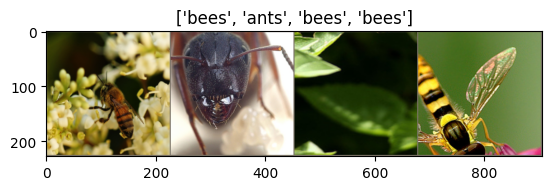

In [23]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

- Scheduling the learning rate
- Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images

In [25]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the ConvNet

With the necessary plumbing out of the way, we can finally start with the actual transfer learning. 

Our first approach to transfer learning is finetuning: We load a pretrained model and reset the final fully connected layer.

In [26]:
model_ft = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training should take around 15-25 min on CPU. On a GPU it takes less than a minute. On Apple Silicon it should be somewhere in between.

In [27]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.5754 Acc: 0.7008
val Loss: 0.2574 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5360 Acc: 0.7992
val Loss: 0.2088 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5285 Acc: 0.7828
val Loss: 0.3846 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.3870 Acc: 0.8484
val Loss: 0.2046 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4622 Acc: 0.8156
val Loss: 1.3160 Acc: 0.6405

Epoch 5/24
----------
train Loss: 0.5196 Acc: 0.7705
val Loss: 0.3431 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5156 Acc: 0.7746
val Loss: 0.9758 Acc: 0.6863

Epoch 7/24
----------
train Loss: 0.3579 Acc: 0.8361
val Loss: 0.2812 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3000 Acc: 0.8852
val Loss: 0.3425 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3341 Acc: 0.8443
val Loss: 0.2825 Acc: 0.8824

Epoch 10/24
----------
train Loss: 0.3201 Acc: 0.8402
val Loss: 0.2688 Acc: 0.8824

Epoch 11/24
----------
train Loss: 0.2468 Acc: 0.8975
val Loss: 0.2929 Acc: 0.8889

Ep

Once training is complete, we can visualize predictions

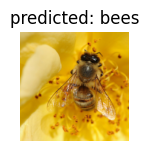

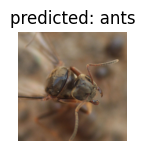

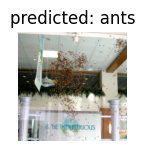

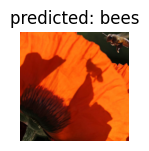

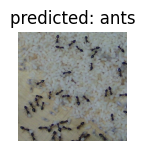

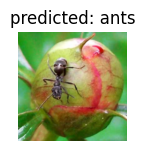

In [28]:
visualize_predictions(model_ft)

### ConvNet as a fixed feature extractor

In our second approach to transfer learning, we freeze all layers of the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

Depending on the task at hand, one could also add more layers after the ConvNet, unfreeze more layers -- the options are endless.

In [29]:
model_conv = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

On a CPU this will take about half the time compared to previous scenario. This is because we only have to compute the gradients for the the final layer.

In [30]:
model_conv = train_model(
    model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.8100 Acc: 0.6311
val Loss: 0.4287 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.7554 Acc: 0.7008
val Loss: 0.3615 Acc: 0.8431

Epoch 2/24
----------
train Loss: 0.4875 Acc: 0.7910
val Loss: 0.2213 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5203 Acc: 0.7910
val Loss: 0.2813 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.3832 Acc: 0.8156
val Loss: 0.2105 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3547 Acc: 0.8361
val Loss: 0.2361 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.5577 Acc: 0.7664
val Loss: 0.2107 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3669 Acc: 0.8443
val Loss: 0.2040 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3472 Acc: 0.8607
val Loss: 0.2242 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3988 Acc: 0.8320
val Loss: 0.2013 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3601 Acc: 0.8443
val Loss: 0.1901 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3595 Acc: 0.8074
val Loss: 0.1994 Acc: 0.9412

Ep

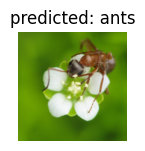

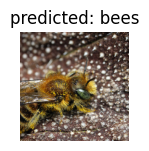

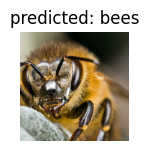

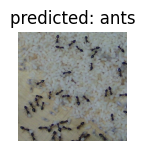

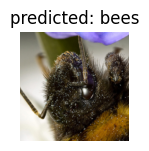

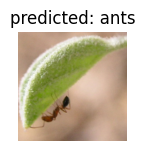

In [ ]:
visualize_predictions(model_conv)

plt.ioff()
plt.show()